## Demo

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
# 使用 NumPy 生成假数据(phony data), 总共 100 个点.
x_data = np.float32(np.random.rand(2, 100)) # 随机输入
y_data = np.dot([0.100, 0.200], x_data) + 0.300

# 构造一个线性模型
# 
b = tf.Variable(tf.zeros([1]))
W = tf.Variable(tf.random_uniform([1, 2], -1.0, 1.0))
y = tf.matmul(W, x_data) + b

# 最小化方差
loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

# 初始化变量
init = tf.initialize_all_variables()

# 启动图 (graph)
sess = tf.Session()
sess.run(init)

# 拟合平面
for step in range(0, 201):
    sess.run(train)
    if step % 20 == 0:
        print(step, sess.run(W), sess.run(b))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 [[0.5485975  0.37857142]] [-0.08228422]
20 [[0.21896014 0.29246715]] [0.19088987]
40 [[0.13351572 0.23480625]] [0.26506203]
60 [[0.11010341 0.21210986]] [0.28869238]
80 [[0.10316775 0.20407614]] [0.2963208]
100 [[0.10101429 0.20135151]] [0.29879972]
120 [[0.10032826 0.20044494]] [0.29960793]
140 [[0.10010681 0.20014599]] [0.29987183]
160 [[0.10003486 0.20004784]] [0.29995808]
180 [[0.10001138 0.20001568]] [0.29998627]
200 [[0.10000371 0.20000513]] [0.2999955]


## Test

In [2]:
a = tf.constant([1.0,2.0], name="cons_a")
b = tf.constant([1.0,2.0], name="cons_b")
result = a + b

sess = tf.Session()
sess.run(result)

array([2., 4.], dtype=float32)

In [24]:
# from https://github.com/eliorc/Medium/blob/master/PCA-tSNE-AE.ipynb
# reference http://projector.tensorflow.org/

import tensorflow as tf
import numpy as np

class TF_PCA:
    def __init__(self, dtype=tf.float32, n_dimensions=None, keep_info=None):
        self.dtype = dtype
        self.n_dimensions = n_dimensions
        self.keep_info = keep_info
        self.graph = None
        self.X = None
        self.u = None
        self.singular_values = None
        self.sigma = None

    def fit(self, data):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X = tf.placeholder(self.dtype, shape=(None, data.shape[1]))

            # Perform SVD
            singular_values, u, components = tf.svd(self.X)

            # Create sigma matrix
            sigma = tf.diag(singular_values)

        with tf.Session(graph=self.graph) as session:
            self.u, self.singular_values, self.sigma, self.components = session.run(
                                                                [u, singular_values, sigma, components],
                                                                feed_dict={self.X: data})

    def transform(self, data):
        if self.keep_info:
            # Normalize singular values
            normalized_singular_values = self.singular_values / sum(self.singular_values)

            # Create the aggregated ladder of kept information per dimension
            ladder = np.cumsum(normalized_singular_values)

            # Get the first index which is above the given information threshold
            index = next(idx for idx, value in enumerate(ladder) if value >= keep_info) + 1
            self.n_dimensions = index

        print("cache information", sum(self.singular_values[:self.n_dimensions])/sum(self.singular_values))
        with self.graph.as_default():
            most_components = tf.slice(self.components, (0,0), (self.components.shape[0], self.n_dimensions))
            new_data = tf.placeholder(dtype=self.dtype, shape=(None, data.shape[1]))
            pca = tf.matmul(new_data, most_components)

        with tf.Session(graph=self.graph) as session:
            return session.run(pca, feed_dict={new_data: data})
    
    def reconstruct(self, weight_value):
        with self.graph.as_default():
            weight = tf.placeholder(self.dtype, shape=(None, self.n_dimensions))
            components = tf.slice(tf.transpose(self.components), 
                                  [0, 0], 
                                  [self.n_dimensions, self.components.shape[1]])
            re_vector = tf.matmul(weight, components)
            
        with tf.Session(graph=self.graph) as session:
            return session.run(re_vector, feed_dict={weight: weight_value})

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data", one_hot=False)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /media/tao/文档/学习/电子书/tensorflow/TensorFlow实战Google深度学习框架/1.0.0/Chapter05/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
scaler = preprocessing.StandardScaler()
scaler.fit(mnist.train.images)
data = mnist.train.images - scaler.mean_

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


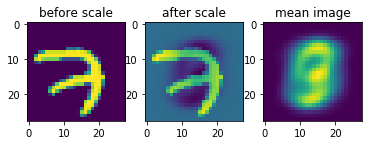

In [5]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(mnist.train.images[0].reshape((28,28)))
ax.set_title("before scale")
ax = fig.add_subplot(132)
ax.imshow(data[0].reshape((28,28)))
ax.set_title("after scale")
ax = fig.add_subplot(133)
ax.imshow(scaler.mean_.reshape((28,28)))
ax.set_title("mean image")
fig.show()

In [25]:
pca = TF_PCA(n_dimensions=14*14)
pca.fit(data)

cache information 0.7612126984520962


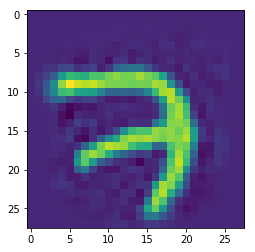

In [30]:
new_data = pca.transform(data)
a = pca.reconstruct(new_data[0].reshape((1,14*14)))
plt.imshow((a+scaler.mean_).reshape((28,28)))

cache information 0.7495891560740073


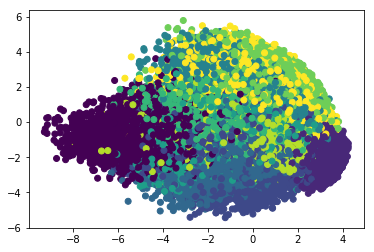

In [108]:
reduced_mnist = pca.transform(data)
plt.scatter(reduced_mnist[:,0], reduced_mnist[:,1],c=mnist.train.labels)

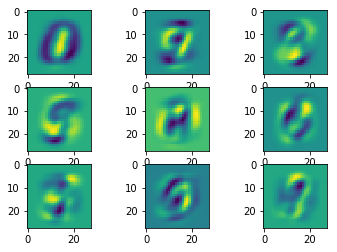

In [110]:
fig = plt.figure()
fig.add_subplot(331).imshow(pca.components[:,0].reshape((28,28)))
fig.add_subplot(332).imshow(pca.components[:,1].reshape((28,28)))
fig.add_subplot(333).imshow(pca.components[:,2].reshape((28,28)))
fig.add_subplot(334).imshow(pca.components[:,3].reshape((28,28)))
fig.add_subplot(335).imshow(pca.components[:,4].reshape((28,28)))
fig.add_subplot(336).imshow(pca.components[:,5].reshape((28,28)))
fig.add_subplot(337).imshow(pca.components[:,6].reshape((28,28)))
fig.add_subplot(338).imshow(pca.components[:,7].reshape((28,28)))
fig.add_subplot(339).imshow(pca.components[:,8].reshape((28,28)))
plt.show()